Saving consumption_user.csv to consumption_user (4).csv
Fișiere încărcate: ['consumption_user (4).csv']
CSV-uri găsite în director: ['subject_user (1).csv', 'subject_user (2).csv', 'consumption_user (2).csv', 'consumption_user (3).csv', 'consumption_user (1).csv', 'consumption_user.csv', 'consumption_user (4).csv', 'subject_user.csv']
✅ Fișier de consum detectat: consumption_user (2).csv
Dimensiune date brute (linii, coloane): (257952, 80)
✅ Coloană folosită ca item: RECIPE_DESCR_ENG
Dimensiune după curățare (linii, coloane): (18290, 2)

--- Exemple (primele 10 rânduri după curățare) ---
     SUBJECT               RECIPE_DESCR_ENG
4          1                     BEANS SOUP
15         1                MASHED POTATOES
22         1          CABBAGE WITH SAUSAGES
38         1                      VEAL SOUP
53         1                   TOMATO SALAD
58         1         SHEEP'S CHEESE PUDDING
71         1                  BEETROOT SOUP
78         1  RICE PILAF WITH CHICKEN LIVER
111      

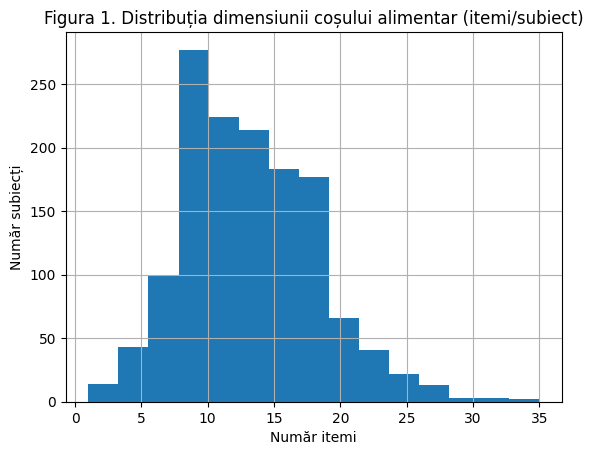

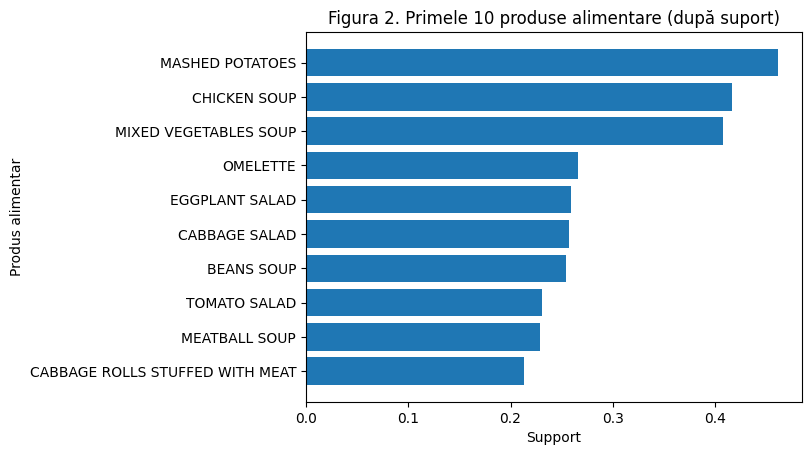

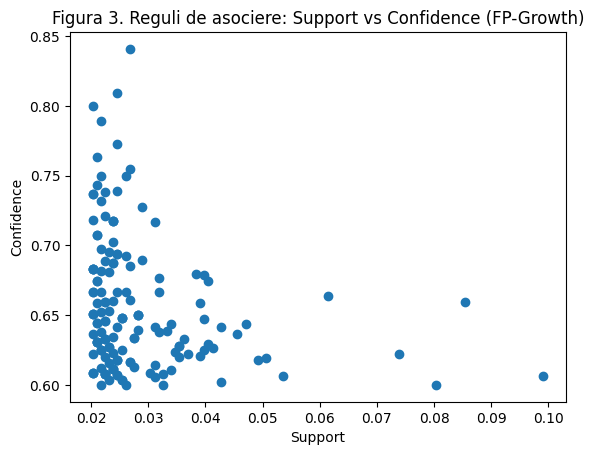

In [10]:
# ============================================================
# FAO GIFT – România 2012 (DIETA PILOT) – Reguli de asociere
# Algoritm alternativ: FP-Growth | Bază de comparație: Apriori
# Google Colab – cod organizat + comentarii în limba română
# ============================================================

# ------------------------------------------------------------
# 0) Setări generale (ascundem warning-urile care pot aglomera output-ul)
# ------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 1) Instalare bibliotecă necesară
# ------------------------------------------------------------
!pip -q install mlxtend

# ------------------------------------------------------------
# 2) Importuri
# ------------------------------------------------------------
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

# ------------------------------------------------------------
# 3) Încărcare fișiere CSV (de obicei: consumption_user.csv etc.)
# ------------------------------------------------------------
uploaded = files.upload()
print("Fișiere încărcate:", list(uploaded.keys()))

# ------------------------------------------------------------
# 4) Detectare automată a fișierului de consum
#    Condiție: să aibă SUBJECT și (RECIPE_DESCR_ENG sau FOODEX2_RECIPE_DESCR)
# ------------------------------------------------------------
csv_files = [f for f in os.listdir() if f.lower().endswith(".csv")]
print("CSV-uri găsite în director:", csv_files)

food_file = None
for f in csv_files:
    try:
        tmp = pd.read_csv(f, nrows=5)
        cols = set(tmp.columns.astype(str))
        if "SUBJECT" in cols and ("RECIPE_DESCR_ENG" in cols or "FOODEX2_RECIPE_DESCR" in cols):
            food_file = f
            break
    except Exception:
        pass

if food_file is None:
    raise ValueError(
        "❌ Nu am găsit fișierul corect de consum.\n"
        "Te rog încarcă un CSV care conține coloana SUBJECT și RECIPE_DESCR_ENG (sau FOODEX2_RECIPE_DESCR)."
    )

print("✅ Fișier de consum detectat:", food_file)

# ------------------------------------------------------------
# 5) Citire date + selectare coloană item (preferăm descrierea în engleză)
# ------------------------------------------------------------
df = pd.read_csv(food_file)
print("Dimensiune date brute (linii, coloane):", df.shape)

item_col = "RECIPE_DESCR_ENG" if "RECIPE_DESCR_ENG" in df.columns else "FOODEX2_RECIPE_DESCR"
print("✅ Coloană folosită ca item:", item_col)

# Păstrăm doar coloanele necesare: SUBJECT (ID tranzacție) + item (rețeta)
df_food = df[["SUBJECT", item_col]].copy()

# ------------------------------------------------------------
# 6) Curățare date (missing + duplicări + stringuri invalide)
# ------------------------------------------------------------
# Convertim SUBJECT la numeric (în caz că vine ca text)
df_food["SUBJECT"] = pd.to_numeric(df_food["SUBJECT"], errors="coerce")

# Eliminăm valorile lipsă
df_food = df_food.dropna(subset=["SUBJECT", item_col])

# Curățăm textul item-ului
df_food[item_col] = df_food[item_col].astype(str).str.strip()

# Eliminăm item-urile goale / "nan"
df_food = df_food[df_food[item_col].str.len() > 0]
df_food = df_food[~df_food[item_col].str.lower().isin(["nan", "none", "null"])]

# Eliminăm duplicările (același subiect a consumat aceeași rețetă de mai multe ori)
df_food = df_food.drop_duplicates(subset=["SUBJECT", item_col])

print("Dimensiune după curățare (linii, coloane):", df_food.shape)
print("\n--- Exemple (primele 10 rânduri după curățare) ---")
print(df_food.head(10))

# ------------------------------------------------------------
# 7) Construire tranzacții (coș alimentar per SUBJECT)
#    Fiecare SUBJECT devine o tranzacție: listă de itemi consumați
# ------------------------------------------------------------
transactions = df_food.groupby("SUBJECT")[item_col].apply(list)
print("\nNumăr tranzacții (SUBJECT unici):", len(transactions))

# Statistici despre dimensiunea coșului
basket_sizes = transactions.apply(len)
print("\n--- Statistici dimensiune coș (items / subiect) ---")
print(basket_sizes.describe())

print("\n--- Exemple tranzacții (5) ---")
for i, (sid, items) in enumerate(transactions.head(5).items(), start=1):
    print(f"{i}) SUBJECT={int(sid)} | nr_itemi={len(items)} | sample={items[:6]}")

# ------------------------------------------------------------
# 8) One-hot encoding (format necesar pentru FP-Growth / Apriori în mlxtend)
# ------------------------------------------------------------
te = TransactionEncoder()
onehot = te.fit(transactions.tolist()).transform(transactions.tolist())
df_onehot = pd.DataFrame(onehot, columns=te.columns_)
print("\nDimensiune one-hot (tranzacții, itemi):", df_onehot.shape)

# ------------------------------------------------------------
# 9) Parametri pentru reguli (se pot ajusta în funcție de rezultate)
# ------------------------------------------------------------
MIN_SUPPORT = 0.02
MIN_CONFIDENCE = 0.60
MIN_LIFT = 1.0

print(f"\n=== Parametri ===\nmin_support={MIN_SUPPORT}, min_confidence={MIN_CONFIDENCE}, min_lift={MIN_LIFT}")

# ------------------------------------------------------------
# 10) FP-Growth (algoritmul alternativ)
# ------------------------------------------------------------
freq_fp = fpgrowth(df_onehot, min_support=MIN_SUPPORT, use_colnames=True)
freq_fp["len"] = freq_fp["itemsets"].apply(len)
freq_fp = freq_fp.sort_values(["support", "len"], ascending=[False, False])

rules_fp = association_rules(freq_fp, metric="confidence", min_threshold=MIN_CONFIDENCE)
rules_fp = rules_fp[rules_fp["lift"] >= MIN_LIFT].copy()

# Facem antecedentele / consecințele mai ușor de citit
rules_fp["antecedents"] = rules_fp["antecedents"].apply(lambda s: ", ".join(sorted(list(s))))
rules_fp["consequents"] = rules_fp["consequents"].apply(lambda s: ", ".join(sorted(list(s))))
rules_fp = rules_fp.sort_values(["lift", "confidence", "support"], ascending=[False, False, False])

print("\n================ FP-GROWTH (REZULTATE) ================")
print("Itemset-uri frecvente:", len(freq_fp))
print("Reguli (după filtrare):", len(rules_fp))
print("\nTop 20 reguli (FP-Growth):")
print(rules_fp[["antecedents","consequents","support","confidence","lift"]].head(20).to_string(index=False))

# ------------------------------------------------------------
# 11) Apriori (algoritmul de bază pentru comparație)
# ------------------------------------------------------------
freq_ap = apriori(df_onehot, min_support=MIN_SUPPORT, use_colnames=True)
freq_ap["len"] = freq_ap["itemsets"].apply(len)
freq_ap = freq_ap.sort_values(["support", "len"], ascending=[False, False])

rules_ap = association_rules(freq_ap, metric="confidence", min_threshold=MIN_CONFIDENCE)
rules_ap = rules_ap[rules_ap["lift"] >= MIN_LIFT].copy()

rules_ap["antecedents"] = rules_ap["antecedents"].apply(lambda s: ", ".join(sorted(list(s))))
rules_ap["consequents"] = rules_ap["consequents"].apply(lambda s: ", ".join(sorted(list(s))))
rules_ap = rules_ap.sort_values(["lift", "confidence", "support"], ascending=[False, False, False])

print("\n================ APRIORI (REZULTATE) ================")
print("Itemset-uri frecvente:", len(freq_ap))
print("Reguli (după filtrare):", len(rules_ap))
print("\nTop 20 reguli (Apriori):")
print(rules_ap[["antecedents","consequents","support","confidence","lift"]].head(20).to_string(index=False))

# ------------------------------------------------------------
# 12) Tabel sumar (comparație rezultate)
# ------------------------------------------------------------
summary = pd.DataFrame({
    "Algoritm": ["FP-Growth", "Apriori"],
    "Itemset-uri frecvente": [len(freq_fp), len(freq_ap)],
    "Reguli (după filtrare)": [len(rules_fp), len(rules_ap)],
    "min_support": [MIN_SUPPORT, MIN_SUPPORT],
    "min_confidence": [MIN_CONFIDENCE, MIN_CONFIDENCE],
    "min_lift": [MIN_LIFT, MIN_LIFT],
})
print("\n================ SUMAR ================")
print(summary.to_string(index=False))

# ------------------------------------------------------------
# 13) Măsurare timp de execuție (comparăm performanța)
# ------------------------------------------------------------
t0 = time.time()
freq_fp_time = fpgrowth(df_onehot, min_support=MIN_SUPPORT, use_colnames=True)
rules_fp_time = association_rules(freq_fp_time, metric="confidence", min_threshold=MIN_CONFIDENCE)
rules_fp_time = rules_fp_time[rules_fp_time["lift"] >= MIN_LIFT]
t_fp = time.time() - t0

t0 = time.time()
freq_ap_time = apriori(df_onehot, min_support=MIN_SUPPORT, use_colnames=True)
rules_ap_time = association_rules(freq_ap_time, metric="confidence", min_threshold=MIN_CONFIDENCE)
rules_ap_time = rules_ap_time[rules_ap_time["lift"] >= MIN_LIFT]
t_ap = time.time() - t0

print("\n================ TIMP EXECUȚIE ================")
print("FP-Growth time (s):", round(t_fp, 4))
print("Apriori time (s):", round(t_ap, 4))

# ------------------------------------------------------------
# 14) Grafice simple (pentru raport)
# ------------------------------------------------------------

# Figura 1: Distribuția dimensiunii coșului alimentar
plt.figure()
basket_sizes.hist(bins=15)
plt.title("Figura 1. Distribuția dimensiunii coșului alimentar (itemi/subiect)")
plt.xlabel("Număr itemi")
plt.ylabel("Număr subiecți")
plt.show()

# Figura 2: Top 10 itemi după suport (itemset-uri de lungime 1)
top_items = (
    freq_fp[freq_fp["itemsets"].apply(len) == 1]
    .sort_values("support", ascending=False)
    .head(10)
)

plt.figure()
plt.barh([list(s)[0] for s in top_items["itemsets"]], top_items["support"])
plt.title("Figura 2. Primele 10 produse alimentare (după suport)")
plt.xlabel("Support")
plt.ylabel("Produs alimentar")
plt.gca().invert_yaxis()
plt.show()

# Figura 3: Support vs Confidence pentru reguli (FP-Growth)
plt.figure()
plt.scatter(rules_fp["support"], rules_fp["confidence"])
plt.title("Figura 3. Reguli de asociere: Support vs Confidence (FP-Growth)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()
